In [57]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 4233

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data

TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = ad_hoc_data(training_size=20,
                                                               test_size=5,
                                                               n=2,
                                                               gap=0.3,
                                                               one_hot=False)

2


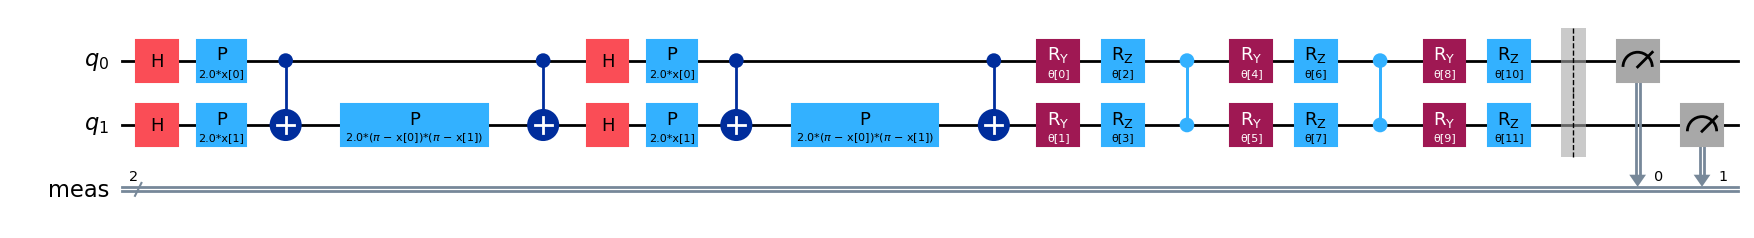

In [2]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

In [10]:
def circuit_instance(data, variational):
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [24]:
def parity(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1)%2

In [22]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0:0, 1:0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts/shots
    return probabilities

In [28]:
from qiskit_aer import Aer
from qiskit import transpile 
def classification_probability(data, variational):
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer
    new_circuit = transpile(circuits, backend=backend)
    results = backend.run(new_circuit).result()
    classifications = [
        label_probability(results.get_counts(c)) for c in circuits
    ]
    return classifications

In [12]:
def cross_entropy_loss(classification, expected):
    p = classification.get(expected)
    return -np.log(p + 1e-10)

In [14]:
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

In [25]:
class OptimizerLog:
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

from qiskit_algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    return cost_function(TRAIN_DATA,TRAIN_LABELS,variational)
result = optimizer.minimize(fun=objective_function, x0=initial_point)

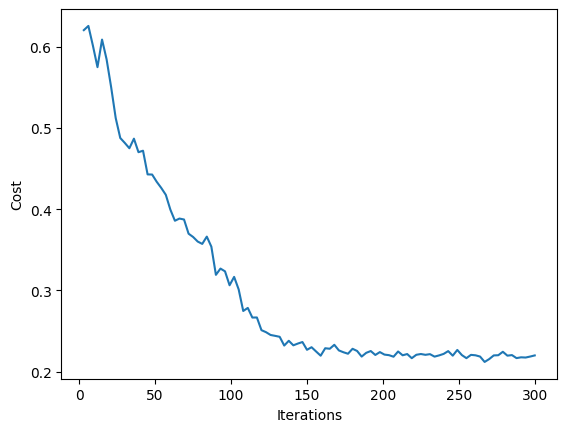

In [26]:
opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
plt.plot(log.evaluations, log.costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [31]:
def test_classifiers(data, labels, variational):
    classifications = classification_probability(data, variational)
    predictions = [0 if c[0] > c[1] else 1 for c in classifications]
    accuracy = 0
    for i, p in enumerate(predictions):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

In [32]:
accuracy, predictions = test_classifiers(TEST_DATA,TEST_LABELS,opt_var)
accuracy

0.9

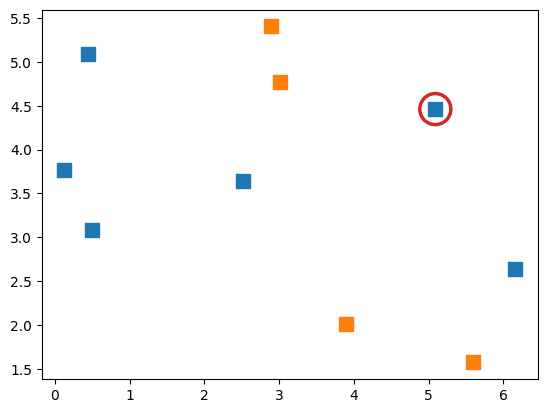

In [34]:
for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

qiskit implementation

In [47]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)).toarray()
test_labels = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)).toarray()

In [48]:
initial_point = np.random.random(VAR_FORM.num_parameters)

from qiskit_machine_learning.algorithms.classifiers import VQC

log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point
          )
from qiskit_aer import AerSimulator
vqc.fit(TRAIN_DATA, TRAIN_LABELS)

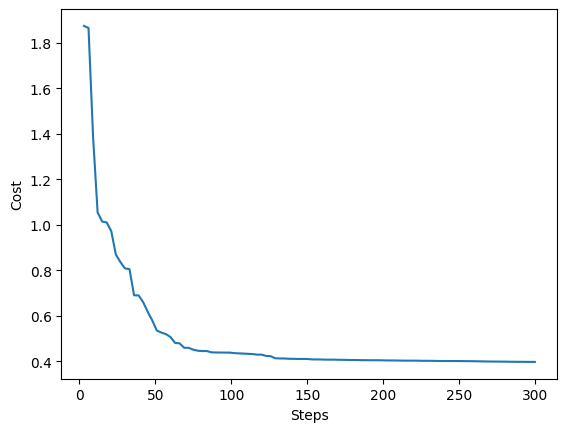

In [49]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()


In [51]:
vqc.score(TEST_DATA, TEST_LABELS)

0.8

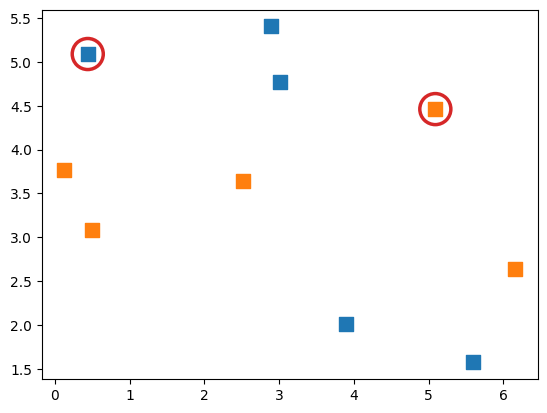

In [54]:
for feature, label, pred in zip(TEST_DATA, TEST_LABELS,
                                vqc.predict(TEST_DATA)):
    COLOR = 'C1' if pred == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

In [102]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli

observable = Pauli('ZZ')
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

from qiskit.primitives import Estimator
estimator = Estimator()
res = estimator.run(circuits=qc, shots=1024, observables=observable).result()
print(res.metadata[0].get('variance'))


3.3306690738754696e-16
